In [1]:
from syft import Worker
import syft as sy
import numpy as np
import pandas as pd
worker = Worker.named("test-domain-1", processes=1, reset=False)
root_domain_client = worker.root_client

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/koen/workspace/PySyft


SQLite Store Path:
!open file:///var/folders/q1/ryq93kwj055dlbpngxv1c7z40000gn/T/7bca415d13ed1ec841f0d0aede098dbb.sqlite

> Starting Worker: test-domain-1 - 7bca415d13ed1ec841f0d0aede098dbb - NodeType.DOMAIN - [<class 'syft.core.node.new.user_service.UserService'>, <class 'syft.core.node.new.metadata_service.MetadataService'>, <class 'syft.core.node.new.action_service.ActionService'>, <class 'syft.core.node.new.test_service.TestService'>, <class 'syft.core.node.new.dataset_service.DatasetService'>, <class 'syft.core.node.new.user_code_service.UserCodeService'>, <class 'syft.core.node.new.request_service.RequestService'>, <class 'syft.core.node.new.data_subject_service.DataSubjectService'>, <class 'syft.core.node.new.network_service.NetworkService'>, <class 'syft.core.node.new.policy_service.PolicyService'>, <class 'syft.core.node.new.message_service.MessageService'>, <class 'syft.core.node.new.project_service.ProjectService'>, <class 'syft.core.node.new.data_subject_member_service.Data

# Summary
By the end of this chapter, we're going to have downloaded all of Canada's weather data for 2012, and saved it to a CSV.

We'll do this by downloading it one month at a time, and then combining all the months together.

## Get mocks

In [2]:
guest_domain_client = worker.guest_client
guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

In [3]:
ds = guest_domain_client.datasets[0]

In [4]:
asset = ds.assets[0]

In [5]:
weather_2012 = asset.mock

## String Operations

You'll see that the 'Weather' column has a text description of the weather that was going on each hour. We'll assume it's snowing if the text description contains "Snow".

pandas provides vectorized string functions, to make it easy to operate on columns containing text. There are some great examples in the documentation.

In [6]:
weather_description = weather_2012['Weather']
is_snowing = weather_description.str.contains('Snow')

This gives us a binary vector, which is a bit hard to look at, so we'll plot it.



In [7]:
# Not super useful
is_snowing[:5]

2010-06-01     True
2010-06-02    False
2010-06-03     True
2010-06-04    False
2010-06-05    False
Name: Weather, dtype: bool

<AxesSubplot: >

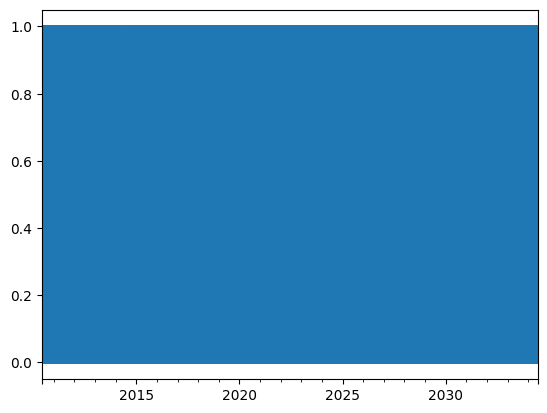

In [8]:
# More useful!
is_snowing=is_snowing.astype(float)
is_snowing.plot()

## Use resampling to find the snowiest month

If we wanted the median temperature each month, we could use the resample() method like this:

In [9]:
weather_2012

,Temp (C),Dew Point Temp (C),Rel Hum (%),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Weather
2010-06-01,8.958393,2.244805,53,15,33.541689,50.021767,"Snow,Haze"
2010-06-02,33.769111,-6.374508,92,16,23.355920,52.996140,Freezing Fog
2010-06-03,34.356803,-8.167022,81,28,7.325819,60.233926,"Snow Showers,Fog"
2010-06-04,28.026779,-0.795635,58,24,26.091763,81.130795,"Drizzle,Ice Pellets,Fog"
2010-06-05,33.841853,-5.157896,80,15,5.819038,73.141499,"Freezing Drizzle,Fog"
...,...,...,...,...,...,...,...
2034-06-14,34.925634,-2.882672,63,12,24.315803,83.342868,"Rain,Snow"
2034-06-15,14.297403,-7.146385,90,4,1.983099,84.813419,Rain
2034-06-16,12.402271,8.734948,56,6,35.024597,55.255596,Freezing Fog
2034-06-17,22.835882,-2.806046,51,26,39.024112,65.049524,Drizzle


<AxesSubplot: >

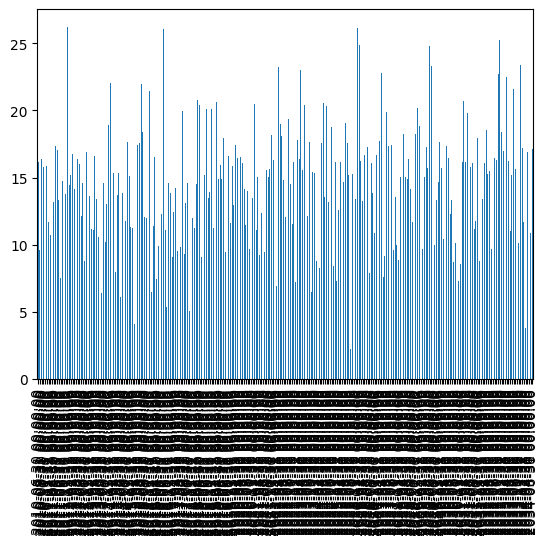

In [10]:
weather_2012['Temp (C)'].resample('M').apply(np.median).plot(kind='bar')

Unsurprisingly, July and August are the warmest.

So we can think of snowiness as being a bunch of 1s and 0s instead of Trues and Falses:

In [11]:
is_snowing.astype(float)[:10]

2010-06-01    1.0
2010-06-02    0.0
2010-06-03    1.0
2010-06-04    0.0
2010-06-05    0.0
2010-06-06    0.0
2010-06-07    1.0
2010-06-08    1.0
2010-06-09    1.0
2010-06-10    0.0
Name: Weather, dtype: float64

and then use resample to find the percentage of time it was snowing each month

In [12]:
is_snowing.astype(float).resample('M').apply(np.mean)

2010-06-30    0.366667
2010-07-31    0.483871
2010-08-31    0.354839
2010-09-30    0.266667
2010-10-31    0.451613
                ...   
2034-02-28    0.357143
2034-03-31    0.290323
2034-04-30    0.366667
2034-05-31    0.322581
2034-06-30    0.333333
Freq: M, Name: Weather, Length: 289, dtype: float64

<AxesSubplot: >

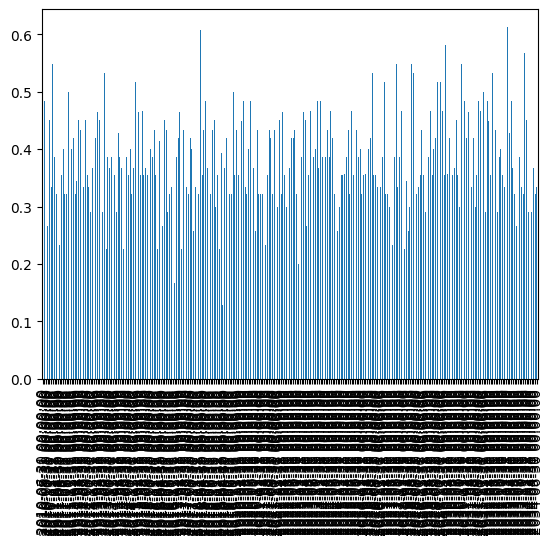

In [13]:
is_snowing.astype(float).resample('M').apply(np.mean).plot(kind='bar')

So now we know! In 2012, December was the snowiest month. Also, this graph suggests something that I feel -- it starts snowing pretty abruptly in November, and then tapers off slowly and takes a long time to stop, with the last snow usually being in April or May.


## Plotting temperature and snowiness stats together

We can also combine these two statistics (temperature, and snowiness) into one dataframe and plot them together:



In [14]:
temperature = weather_2012['Temp (C)'].resample('M').apply(np.median)
is_snowing = weather_2012['Weather'].str.contains('Snow')
snowiness = is_snowing.astype(float).resample('M').apply(np.mean)

# Name the columns
temperature.name = "Temperature"
snowiness.name = "Snowiness"

We'll use `concat` again to combine the two statistics into a single dataframe.

In [15]:
stats = pd.concat([temperature, snowiness], axis=1)

In [16]:
stats.columns = ["temperature", "snowiness"]

## Putting it together

Now we want to request the full code execution.

Let's put all that together, to prove how easy it is. 6 lines of magical pandas!

If you want to play around, try changing sum to max, numpy.median, or any other function you like.

In [17]:
@sy.syft_function(input_policy=sy.ExactMatch(df=ds.assets[0]),
                  output_policy=sy.SingleExecutionExactOutput())
def snow_and_temperature(df):
    import pandas as pd
    import numpy as np
    weather_2012 = df
    weather_description = weather_2012['Weather']
    is_snowing = weather_description.str.contains('Snow')
    
    median_temperature = weather_2012['Temp (C)'].resample('M').apply(np.median)
    snow_frequency = is_snowing.astype(float).resample('M').apply(np.mean)
    
    temperature = weather_2012['Temp (C)'].resample('M').apply(np.median)
    is_snowing = weather_2012['Weather'].str.contains('Snow')
    snowiness = is_snowing.astype(float).resample('M').apply(np.mean)

    # Name the columns
    temperature.name = "Temperature"
    snowiness.name = "Snowiness"
    stats = pd.concat([temperature, snowiness], axis=1)
    stats.columns = ["temperature", "snowiness"]
    
    return is_snowing.astype(float), median_temperature, snow_frequency, stats

Request code execution

In [18]:
req = guest_domain_client.api.services.code.request_code_execution(snow_and_temperature)

In [19]:
submitted_code = guest_domain_client.code[0]

In [20]:
assert guest_domain_client.api.services.code.get_all()

Create and submit project

In [21]:
new_project = sy.Project(name="Pandas Chapter 5",
                         description="Hi, I would like to get some insights about snow and temperature for 2012")

In [22]:
new_project.add_request(obj=submitted_code, permission=sy.UserCodeStatus.EXECUTE)

In [23]:
guest_domain_client.submit_project(new_project)

<class 'syft.core.node.new.response.SyftSuccess'>: Project Submitted